In [158]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import json
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

In [108]:
df = pd.read_csv('minified_dataframe.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [156]:
len(df[df.propaganda==0])

31972

In [110]:
X = df[df.columns[:-2]]
y = df[['propaganda','non_propaganda']]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [135]:
# Make sure the training and testing data both sample from each class
prop_X_train, prop_X_test, prop_y_train, prop_y_test = train_test_split(X.iloc[31972:], y.iloc[31972:], test_size=0.2)
non_prop_X_train, non_prop_X_test, non_prop_y_train, non_prop_y_test = train_test_split(X.iloc[:31972], y.iloc[:31972], test_size=0.2)

train_Xs = pd.concat([prop_X_train, non_prop_X_train])
train_ys = pd.concat([prop_y_train, non_prop_y_train])
training_data = pd.concat([train_Xs, train_ys], axis=1)

X_test = pd.concat([prop_X_test, non_prop_X_test])
y_test = pd.concat([prop_y_test, non_prop_y_test])
testing_data = pd.concat([test_Xs, test_ys], axis=1)

# Balance class sizes in training data
df_majority = training_data[training_data.propaganda==0]
df_minority = training_data[training_data.propaganda==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42) 
training_data = pd.concat([df_majority, df_minority_upsampled])

X_train = training_data[training_data.columns[:-2]]
y_train = training_data[['propaganda','non_propaganda']]


# Balance class sizes in test data
df_majority = testing_data[testing_data.propaganda==0]
df_minority = testing_data[testing_data.propaganda==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42) 
testing_data = pd.concat([df_majority, df_minority_upsampled])

X_test = testing_data[testing_data.columns[:-2]]
y_test = testing_data[['propaganda','non_propaganda']]


In [137]:
# Helper function 
def print_scores(preds):
    print("Precision: %f" % precision_score(y_test['propaganda'],preds, average='binary'))
    print("Recall: %f" % recall_score(y_test['propaganda'],preds, average='binary'))
    print("F1 Score: %f" % f1_score(y_test['propaganda'],preds, average='binary'))

In [138]:
# Baseline model, random choice
baseline_preds = np.random.choice(2, len(y_test))
print_scores(baseline_preds)

Precision: 0.492848
Recall: 0.495700
F1 Score: 0.494270


In [139]:
# Gaussian Naive bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train['propaganda'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [141]:
nb_preds = nb_clf.predict(X_test)
print_scores(nb_preds)

Precision: 0.645233
Recall: 0.588428
F1 Score: 0.615523


In [142]:
# SVM
svm_clf = SVC(C=1, gamma='auto',random_state=42)
svm_clf.fit(X_train, y_train['propaganda'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [143]:
svm_preds = svm_clf.predict(X_test)
print_scores(svm_preds)

Precision: 0.709299
Recall: 0.727600
F1 Score: 0.718333


In [144]:
# Linear SVM
lin_svc_clf = LinearSVC(C=1.0, class_weight='balanced', random_state=42, max_iter=10000)
lin_svc_clf.fit(X_train, y_train['propaganda'])

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [145]:
lin_svc_preds = lin_svc_clf.predict(X_test)
print_scores(lin_svc_preds)

Precision: 0.683943
Recall: 0.693354
F1 Score: 0.688616


In [146]:
# KNN classifier
neigh_clf = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
neigh_clf.fit(X_train, y_train['propaganda']) 

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [147]:
neigh_clf_preds = neigh_clf.predict(X_test)
print_scores(neigh_clf_preds)

Precision: 0.827765
Recall: 0.848475
F1 Score: 0.837992


In [148]:
# Random Forrest classification
random_forrest_clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
random_forrest_clf.fit(X_train, y_train['propaganda'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [149]:
random_forrest_preds = random_forrest_clf.predict(X_test)
print_scores(random_forrest_preds)

Precision: 0.955692
Recall: 0.853323
F1 Score: 0.901611


In [150]:
# Multilayer_perceptron classifier
mlp = MLPClassifier(learning_rate_init=0.1,hidden_layer_sizes=((128,256)), random_state=42, 
                    max_iter=5000, early_stopping=False, activation='identity', learning_rate='adaptive')
mlp.fit(X_train, y_train['propaganda'])

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128, 256), learning_rate='adaptive',
       learning_rate_init=0.1, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [151]:
mlp_preds = mlp.predict(X_test)
print_scores(mlp_preds)

Precision: 0.654691
Recall: 0.769351
F1 Score: 0.707405


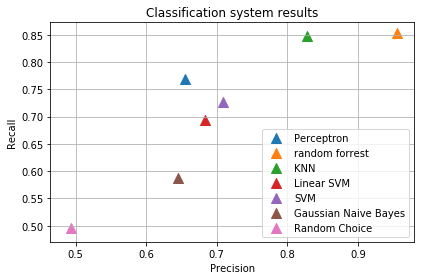

In [170]:
predictions = [ mlp_preds,random_forrest_preds, neigh_clf_preds, lin_svc_preds, svm_preds, nb_preds, baseline_preds]
names = [ 'Perceptron','random forrest','KNN','Linear SVM', 'SVM', 'Gaussian Naive Bayes', 'Random Choice']
results = []
plt.figure(0)
for i,n in zip(predictions,names):
    res = [n]
    p = precision_score(y_test['propaganda'], i, average='binary')
    r = recall_score(y_test['propaganda'], i, average='binary')
    plt.scatter(p,r, label=n,marker='^', s=100)
    res.append(p)
    res.append(r)
    res.append(f1_score(y_test['propaganda'], i, average='binary'))
    results.append(res)
plt.legend()
plt.title("Classification system results")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.tight_layout()
plt.savefig('classification_results.pdf')

In [167]:
word_dict = {}
with open('word_dict.json') as f:
    word_dict = json.load(f)

In [168]:
len(word_dict.keys())

207185

In [169]:
results

[['Perceptron', 0.654690618762475, 0.7693510555121188, 0.7074047447879224],
 ['random forrest', 0.95569176882662, 0.853322908522283, 0.9016109045848822],
 ['KNN', 0.8277650648360031, 0.8484753713838936, 0.837992277992278],
 ['LinearSVC', 0.6839426191577973, 0.6933541829554339, 0.6886162447585029],
 ['SVM', 0.7092987804878049, 0.7275996872556685, 0.7183326900810498],
 ['Gaussian Naive Bayes',
  0.6452331961591221,
  0.5884284597341674,
  0.6155230228183528],
 ['Random Choice',
  0.49284825870646765,
  0.49569976544175137,
  0.494269899430888]]